In [1]:
import os
import math

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear

import torch_geometric as tg
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import CGConv, NNConv, Set2Set
from torch_geometric.nn.aggr import AttentionalAggregation

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, PredefinedSplit
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from sklearn.base import BaseEstimator, RegressorMixin

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import rdkit
from rdkit import Chem
import rdkit.Chem.rdchem as rdc

import matplotlib.pyplot as plt


In [2]:
import sys
sys.path.append(os.getcwd())

from src.load_utils import *
from src.feature_importance import *

# Hyperparameters/Target Labels

In [3]:
# Labels/Hyperparameter definition

target_cols_labels = [
    "CONDUCTIVITY",
    "TFSI Diffusivity",
    "Li Diffusivity",
    "Poly Diffusivity",
    "Transference Number",
]

csv_path = 'data/temp_full_data.csv'

# Training Parameters
batch_size = 256
num_epochs = 200

# Hidden layer parameters
fea_dim=96
n_layers=4
n_hidden=2

# Adam optimizer hyperparameters
learning_rate = 1e-4
weight_decay = 1e-6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
save_dir = "model_out"
os.makedirs(save_dir, exist_ok=True)

# Function definition for data processing

In [ ]:
# Setup feature ranges based on SMILES strings

def compute_feature_ranges(list_of_smiles):
    # node/atom features
    atom_symbols = set()
    degrees = set()
    formal_charges = set()
    num_hs = set()
    hybridizations = set()
    
    # edge/bond features
    bond_types = set()
    bond_stereo = set()
    conjugations = set()

    for smile in list_of_smiles:

        mol = Chem.MolFromSmiles(smile)
        if mol is None:
            continue # only process valid SMILES strings

        for atom in mol.GetAtoms():
            # add relevant atom features
            atom_symbols.add(atom.GetSymbol())
            degrees.add(atom.GetDegree())
            formal_charges.add(atom.GetFormalCharge())
            num_hs.add(atom.GetTotalNumHs())
            hybridizations.add(str(atom.GetHybridization()))

        for bond in mol.GetBonds():
            # add relevant bond features
            bond_types.add(str(bond.GetBondType()))
            bond_stereo.add(str(bond.GetStereo()))
            conjugations.add(bond.GetIsConjugated())
    
    x_map = {
        "atomic_symbol": sorted(atom_symbols),
        "degree": sorted(degrees),
        "formal_charge": sorted(formal_charges),
        "num_hs": sorted(num_hs),
        "hybridization": sorted(hybridizations),
        "is_aromatic": [False, True],
        "is_in_ring": [False, True],
    }

    e_map = {
        "bond_type": sorted(bond_types),
        "stereo": sorted(bond_stereo),
        "is_conjugated": [False, True],
    }
    return x_map, e_map # feature ranges will be based off of entire dataset

def add_unknowns(x_map: dict, e_map: dict): # in case of unseens feature categories
    # Add UNK token to categorical lists if not present
    for k in ["atomic_symbol", "hybridization"]:
        if "UNK" not in x_map[k]:
            x_map[k].append("UNK")
    # For degree/formal_charge/num_hs: we will keep them as discrete sets but
    # if unseen values appear we will map to a min/max or UNK index — we append 'UNK' as str to be safe.
    for k in ["degree", "formal_charge", "num_hs"]:
        if "UNK" not in x_map[k]:
            x_map[k] = list(x_map[k]) + ["UNK"]

    for k in ["bond_type", "stereo"]:
        if "UNK" not in e_map[k]:
            e_map[k].append("UNK")

    # ensure boolean lists contain False/True, 0/1
    x_map['is_aromatic'] = [False, True]
    x_map['is_in_ring'] = [False, True]
    e_map['is_conjugated'] = [False, True]

    return x_map, e_map

def get_bond_feature_dim(e_map):
    dim = (
        len(e_map["bond_type"]) +
        len(e_map["stereo"]) +
        len(e_map["is_conjugated"])
    )
    return dim

In [ ]:
# Feature Definition: one-hot, atom (node), bond (edge), generate graph from SMILES

def one_hot(x, choices):
    if x not in choices:
        x = "UNK"
    return np.array([x == c for c in choices], dtype=float)

def atom_features(atom, x_map):
    symbol = atom.GetSymbol()
    degree = atom.GetDegree()
    fc = atom.GetFormalCharge()
    hs = atom.GetTotalNumHs()
    hyb = str(atom.GetHybridization())
    aromatic = atom.GetIsAromatic()
    ring = atom.IsInRing()

    return np.concatenate([
        one_hot(symbol, x_map["atomic_symbol"]),
        one_hot(degree, x_map["degree"]),
        one_hot(fc, x_map["formal_charge"]),
        one_hot(hs, x_map["num_hs"]),
        one_hot(hyb, x_map["hybridization"]),
        one_hot(aromatic, x_map["is_aromatic"]),
        one_hot(ring, x_map["is_in_ring"]),
    ])


def bond_features(bond, e_map):
    btype = str(bond.GetBondType())
    stereo = str(bond.GetStereo())
    conj = bond.GetIsConjugated()

    return np.concatenate([
        one_hot(btype, e_map["bond_type"]),
        one_hot(stereo, e_map["stereo"]),
        one_hot(conj, e_map["is_conjugated"]),
    ])

def smiles_to_graph(smiles, x_map, e_map, add_h: bool = True, add_self_loops=True):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")
    if add_h:
        mol = Chem.AddHs(mol)
    
    atom_feats = []
    edge_index = []
    edge_feats = []

    # Atom features
    for atom in mol.GetAtoms():
        atom_feats.append(atom_features(atom, x_map))

    # Bond features
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        bf = bond_features(bond, e_map)
        edge_index.append([i, j])
        edge_feats.append(bf)

        edge_index.append([j, i])
        edge_feats.append(bf)

    if add_self_loops: # self "bond"
        bond_dim = (
            len(e_map["bond_type"]) +
            len(e_map["stereo"]) +
            len(e_map["is_conjugated"])
        )
        zero_bond = np.zeros(bond_dim, dtype=float)

        num_atoms = len(atom_feats)
        for i in range(num_atoms):
            edge_index.append([i, i])
            edge_feats.append(zero_bond)

    x = torch.tensor(np.array(atom_feats), dtype=torch.float)
    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.long)
    edge_attr = torch.tensor(np.array(edge_feats), dtype=torch.float)
    
    g = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    g.num_nodes = x.size(0)
    
    return g # uniquely shaped graph for each SMILES

In [6]:
# Process CSV file, generate graphs

class PolymerCSV(InMemoryDataset):
    def __init__(self, csv_path: str, target_cols: list[str], x_map: dict, e_map: dict, add_h: bool = True):
        super().__init__(None)
        self.df = pd.read_csv(csv_path)
        self.target_cols = target_cols
        
        self.x_map = x_map
        self.e_map = e_map
        self.add_h = add_h

        data_list = []
        for idx, row in self.df.iterrows():
            smi = row.get("Mol_smiles_clean")
            if pd.isna(smi):
                continue
            try:
                g = smiles_to_graph(smi, self.x_map, self.e_map, self.add_h, True)
            except Exception as e:
                print(f"[Warning] Skipping SMILES {smi}: {e}")
                continue

            # collect targets and mask
            y = []
            mask = []
            for c in self.target_cols:
                val = row.get(c, np.nan) # get column value or NaN if unavailable
                if pd.isna(val):
                    y.append(0.0)
                    mask.append(0.0)
                else:
                    y.append(float(val))
                    mask.append(1.0)

            g.y = torch.tensor([y], dtype=torch.float)
            g.y_mask = torch.tensor([mask], dtype=torch.float)
            
            # optional: save trajectory id as meta
            if "Trajectory ID" in row:
                g.traj_id = int(row["Trajectory ID"])
            data_list.append(g)

        self.data, self.slices = self.collate(data_list)

# Convolutional Neural Network Setup

In [ ]:
# Multitask CGCNN setup

class MultiTaskCGCNN(nn.Module):
    def __init__(self, node_in: int, edge_in: int, fea_dim=96, n_layers=4, n_hidden=2, out_dim=5, include_mol_features=False, mol_dim=0):
        super().__init__()
        self.node_embed = Linear(node_in, fea_dim)
        self.edge_embed = Linear(edge_in, fea_dim)
        self.include_mol_features = include_mol_features
        self.mol_dim = mol_dim

        self.convs = nn.ModuleList([
            CGConv(channels=fea_dim, dim=fea_dim, aggr="mean", batch_norm=True)
            for _ in range(n_layers)
        ])

        self.pool = AttentionalAggregation(
            gate_nn=Sequential(Linear(fea_dim, fea_dim), Linear(fea_dim, 1)),
            nn=Sequential(Linear(fea_dim, fea_dim), Linear(fea_dim, fea_dim))
        )

        if self.include_mol_features:
            if self.mol_dim == 0:
                raise ValueError("Must supply number of molecular features (>0)")
            fea_dim += self.mol_dim
        self.hiddens = nn.ModuleList([Linear(fea_dim, fea_dim) for _ in range(n_hidden)])
        self.head = Linear(fea_dim, out_dim)

    def forward(self, data: tuple[Data, torch.Tensor]):
        graph_data, mol_data = data
        x = F.leaky_relu(self.node_embed(graph_data.x)) # leaky ReLU for activation
        e = F.leaky_relu(self.edge_embed(graph_data.edge_attr)) # nodes and edges
        
        for conv in self.convs: # convolutional layers
            x = conv(x, graph_data.edge_index, e)
        g = self.pool(x, graph_data.batch) # pool after n_layers
        
        if self.include_mol_features: # concatenate pooled graph data with molecular data (optional)
            g = torch.cat((g, mol_data), dim=1)
        
        for h in self.hiddens: # pass through n_hidden layers
            g = F.leaky_relu(h(g))

        out = self.head(g) # outputs vector predicting desired properties
        return out

In [8]:
# Masked MSE & MAE

def masked_mse_loss(pred: torch.Tensor, y: torch.Tensor, mask: torch.Tensor):
    # pred,y,mask -> [B, T]
    
    diff = (pred - y) * mask
    denom = mask.sum()
    if denom.item() == 0:
        return torch.tensor(0.0, device=pred.device, requires_grad=True)
    return (diff * diff).sum() / denom


def masked_mae(pred: np.ndarray, y: np.ndarray, mask: np.ndarray):
    # numpy arrays
    diff = np.abs(pred - y) * mask
    denom = mask.sum()
    if denom == 0:
        return 0.0
    return diff.sum() / denom

In [ ]:
# Train and evaluate epochs

def train_epoch(model, loader, optimizer, scaler: StandardScaler, device):
    model.train()
    total_loss = 0.0
    for batch1, batch2 in loader: # batch1 = graph data, batch2 = molecular data
        batch1 = batch1.to(device)
        batch2 = batch2.to(device)
        # scale batch targets using scaler trained on train set only
        y_cpu = batch1.y.cpu().numpy()
        y_scaled = torch.tensor(scaler.transform(y_cpu), dtype=torch.float, device=device)

        optimizer.zero_grad()
        out = model((batch1, batch2))
        loss = masked_mse_loss(out, y_scaled, batch1.y_mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch1.num_graphs # collect loss from each graph
    
    loss = total_loss / len(loader.dataset)
    return loss


def eval_epoch(model, loader, scaler: StandardScaler, device):
    model.eval()
    total_loss = 0.0

    all_preds = []
    all_preds_scaled = []
    all_ys = []
    all_ys_scaled = []
    all_masks = []

    with torch.no_grad(): # evaluation should not update model
        for batch1, batch2 in loader:
            batch1 = batch1.to(device)
            batch2 = batch2.to(device)

            y_cpu = batch1.y.cpu().numpy()
            y_scaled_np = scaler.transform(y_cpu)
            y_scaled = torch.tensor(y_scaled_np, dtype=torch.float, device=device)

            out_scaled = model((batch1, batch2))
            out_scaled_np = out_scaled.cpu().numpy()

            loss = masked_mse_loss(out_scaled, y_scaled, batch1.y_mask)
            total_loss += loss.item() * batch1.num_graphs

            out_unscaled = scaler.inverse_transform(out_scaled.cpu().numpy())
            y_unscaled = batch1.y.cpu().numpy()  # raw y already unscaled

            all_preds.append(out_unscaled)
            all_preds_scaled.append(out_scaled_np)
            all_ys.append(y_unscaled)
            all_ys_scaled.append(y_scaled_np)

            all_masks.append(batch1.y_mask.cpu().numpy())

    if len(all_preds) == 0:
        return total_loss / max(1, len(loader.dataset)), None

    preds = np.vstack(all_preds)
    preds_scaled = np.vstack(all_preds_scaled)
    ys = np.vstack(all_ys)
    ys_scaled = np.vstack(all_ys_scaled)
    masks = np.vstack(all_masks)


    # per task loss/MAE
    T = preds.shape[1]
    per_task_mae = []
    per_task_r2 = []

    for t in range(T):
        mask_t = masks[:, t].astype(bool)

        if mask_t.sum() == 0:
            per_task_mae.append(None)
            per_task_r2.append(None)
            continue

        pred_t = preds_scaled[:, t][mask_t]
        y_t = ys_scaled[:, t][mask_t]

        mae_t = np.mean(np.abs(pred_t - y_t))
        per_task_mae.append(mae_t)

        if len(y_t) > 1:
            per_task_r2.append(r2_score(y_t, pred_t))
        else:
            per_task_r2.append(None)
            
    # compute global loss/MAE across all tasks using masking
    overall_loss = total_loss / len(loader.dataset)
    overall_mae = masked_mae(preds, ys, masks)
    overall_r2 = np.mean(per_task_r2)

    return overall_loss, overall_mae, overall_r2, per_task_mae, per_task_r2, preds, ys, masks

In [10]:
# Create training, validation, testing splits

def create_splits(df: pd.DataFrame, frac_train=0.8, frac_val=0.125):
    n = len(df)
    test_size = 1.0 - frac_train
    idx = np.arange(n)
    train_idx, test_idx = train_test_split(idx, test_size=test_size)
    train_idx, val_idx = train_test_split(train_idx, test_size=frac_val / frac_train)

    return train_idx.tolist(), val_idx.tolist(), test_idx.tolist()

In [ ]:
### Build, train, and test model

def model_execution(csv_path=csv_path,
                    target_cols=target_cols_labels,
                    include_mol_features=False,
                    batch_size=batch_size,
                    num_epochs=num_epochs,
                    fea_dim=fea_dim,
                    n_layers=n_layers,
                    n_hidden=n_hidden,
                    learning_rate=learning_rate,
                    weight_decay=weight_decay,
                    return_predictions=False,
                    verbose=0):

    # Load CSV + build feature maps
    df = pd.read_csv(csv_path)
    smiles_list = df["Mol_smiles_clean"].dropna().astype(str).tolist()

    mol_cols = [
        c for c in df.columns if c not in [*target_cols, "Mol_smiles_clean", 'Unnamed: 0']
    ]
    mol_data = torch.tensor(df[mol_cols].values, dtype=torch.float32)

    x_map, e_map = compute_feature_ranges(smiles_list)
    x_map, e_map = add_unknowns(x_map, e_map)

    # Train/val/test splits
    train_idx, val_idx, test_idx = create_splits(df, frac_train=0.8, frac_val=0.125)

    dataset = PolymerCSV(csv_path, target_cols, x_map=x_map, e_map=e_map, add_h=True)

    if verbose:
        print(f"Found {len(smiles_list)} SMILES in CSV.")

        print("\n ===> Atom feature map sizes <===")
        for k, v in x_map.items():
            print(f"{k:>15}: {len(v)}")

        print("\n ===> Edge feature map sizes <===")
        for k, v in e_map.items():
            print(f"{k:>15}: {len(v)}")

        print(f"\nSplit sizes:\n   Training = {len(train_idx)}\n   Validation = {len(val_idx)}\n   Testing = {len(test_idx)}")
        print(f"\nTotal graphs built: {len(dataset)}")

    train_ds = torch.utils.data.Subset(dataset, train_idx)
    val_ds   = torch.utils.data.Subset(dataset, val_idx)
    test_ds  = torch.utils.data.Subset(dataset, test_idx)
    
    train_mol_ds = torch.utils.data.Subset(mol_data, train_idx)
    val_mol_ds   = torch.utils.data.Subset(mol_data, val_idx)
    test_mol_ds  = torch.utils.data.Subset(mol_data, test_idx)

    train_loader = DataLoader([(d, v) for d, v in zip(train_ds, train_mol_ds)], batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader([(d, v) for d, v in zip(val_ds, val_mol_ds)],     batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader([(d, v) for d, v in zip(test_ds, test_mol_ds)],   batch_size=batch_size, shuffle=False)

    # Fit scaler only on training targets
    def collect_targets(subset):
        Ys = [g.y.numpy() for g in subset]
        return np.vstack(Ys) if Ys else np.zeros((0, len(target_cols)))

    y_train = collect_targets(train_ds)
    if y_train.shape[0] == 0:
        raise RuntimeError("No training examples with targets found!")

    scaler = StandardScaler()
    scaler.fit(y_train)

    # Build model + optimizer
    sample = dataset[0]
    node_in = sample.x.shape[1]
    edge_in = sample.edge_attr.shape[1]
    out_dim = len(target_cols)
    mol_dim = len(mol_cols)

    model = MultiTaskCGCNN(
        node_in=node_in,
        edge_in=edge_in,
        fea_dim=fea_dim,
        n_layers=n_layers,
        n_hidden=n_hidden,
        out_dim=out_dim,
        include_mol_features=include_mol_features,
        mol_dim=mol_dim
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    best_val = float("inf")

    if include_mol_features:
        model_state_name = 'naive_model_nomol'
    else:
        model_state_name = 'naive_model_withmol'

    best_path = os.path.join(save_dir, f"{model_state_name}.pth")

    # Unified metrics structure
    metrics = {
        "train": {
            "loss": [],
            "mae":  [],
            "r2":   [],
            "per_task_mae": {t: [] for t in target_cols},
            "per_task_r2":  {t: [] for t in target_cols},
        },
        "val": {
            "loss": [],
            "mae":  [],
            "r2":   [],
            "per_task_mae": {t: [] for t in target_cols},
            "per_task_r2":  {t: [] for t in target_cols},
        },
        "test": {
            "loss": None,
            "mae":  None,
            "r2":   None,
            "per_task_mae": {t: None for t in target_cols},
            "per_task_r2":  {t: None for t in target_cols},
        }
    }


    # Training loop
    for epoch in tqdm(range(1, num_epochs + 1)):

        # training
        train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
        tr_loss, tr_mae, tr_r2, tr_pt_mae, tr_pt_r2, _, _, _ = eval_epoch(
            model, train_loader, scaler, device
        )
        tr_loss = train_loss   # override with actual loss from train_epoch

        # validation
        val_loss, val_mae, val_r2, val_pt_mae, val_pt_r2, _, _, _ = eval_epoch(
        model, test_loader, scaler, device
    )

        # store metrics
        metrics["train"]["loss"].append(tr_loss)
        metrics["train"]["mae"].append(tr_mae)
        metrics["train"]["r2"].append(tr_r2)

        metrics["val"]["loss"].append(val_loss)
        metrics["val"]["mae"].append(val_mae)
        metrics["val"]["r2"].append(val_r2)

        for i, t in enumerate(target_cols):
            metrics["train"]["per_task_mae"][t].append(tr_pt_mae[i])
            metrics["train"]["per_task_r2"][t].append(tr_pt_r2[i])
            metrics["val"]["per_task_mae"][t].append(val_pt_mae[i])
            metrics["val"]["per_task_r2"][t].append(val_pt_r2[i])

        # checkpoint
        if val_loss < best_val:
            best_val = val_loss
            torch.save(
                {
                    "model_state": model.state_dict(),
                    "scaler": scaler,
                    "x_map": x_map,
                    "e_map": e_map,
                    "metrics": metrics,
                },
                best_path,
            )

    # Final test evaluation
    ckpt = torch.load(best_path, map_location=device, weights_only=False)

    model.load_state_dict(ckpt["model_state"])
    scaler = ckpt["scaler"]

    test_loss, test_mae, test_r2, test_pt_mae, test_pt_r2, test_preds, test_ys, test_masks = eval_epoch(
        model, test_loader, scaler, device
    )

    metrics["test"]["loss"] = test_loss
    metrics["test"]["mae"]  = test_mae
    metrics["test"]["r2"]   = test_r2
    for i, t in enumerate(target_cols):
        metrics["test"]["per_task_mae"][t] = test_pt_mae[i]
        metrics["test"]["per_task_r2"][t]  = test_pt_r2[i]

    if return_predictions:
        return model, metrics, scaler, test_preds, test_ys, test_masks
    else:
        return model, metrics, scaler


In [12]:
# Plot metrics for final model

def plot_all_metrics(metrics, target_cols, num_epochs):
    epochs = np.arange(1, num_epochs + 1)


    fig_global, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(18,6))

    # GLOBAL LOSS
    ax1.grid(True)
    ax1.plot(epochs, metrics["train"]["loss"], label="Train Loss")
    ax1.plot(epochs, metrics["val"]["loss"],   label="Val Loss")
    ax1.scatter([num_epochs], [metrics["test"]["loss"]], color="red", label="Test Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Scaled MSE Loss")
    ax1.set_title("Global Loss")
    ax1.legend()

    # GLOBAL MAE
    ax2.grid(True)
    ax2.plot(epochs, metrics["train"]["mae"], label="Train MAE")
    ax2.plot(epochs, metrics["val"]["mae"],   label="Val MAE")
    ax2.scatter([num_epochs], [metrics["test"]["mae"]], color="red", label="Test MAE")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("MAE")
    ax2.set_title("Global MAE")
    ax2.legend()

    # GLOBAL R2
    ax3.grid(True)
    ax3.plot(epochs, metrics["train"]["r2"], label="Train R2")
    ax3.plot(epochs, metrics["val"]["r2"],   label="Val R2")
    ax3.scatter([num_epochs], [metrics["test"]["r2"]], color="red", label="Test R2")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("R2 Score")
    ax3.set_title("Global R2")
    ax3.legend()

    fig_global.tight_layout()
    plt.show()

    # PER-TASK MAE SUBPLOTS
    T = len(target_cols)
    ncols = math.ceil(math.sqrt(T))
    nrows = math.ceil(T / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 12))
    axes = axes.flatten()

    for idx, t in enumerate(target_cols):
        ax = axes[idx]
        train_vals = metrics["train"]["per_task_mae"][t]
        val_vals   = metrics["val"]["per_task_mae"][t]
        test_val   = metrics["test"]["per_task_mae"][t]

        ax.plot(epochs, train_vals, label="Train", linewidth=2)
        ax.plot(epochs, val_vals,   label="Val",   linewidth=2)
        if test_val is not None:
            ax.scatter([num_epochs], [test_val], color="red", s=40, label="Test")

        ax.set_title(f"{t} — MAE")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("MAE")
        ax.grid(True)
        ax.legend()

    # hide any unused axes
    for j in range(idx+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Per-Task MAE Over Time", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

    # PER-TASK R2 SUBPLOTS
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 12))
    axes = axes.flatten()

    for idx, t in enumerate(target_cols):
        ax = axes[idx]
        ax.grid(True)

        train_vals = metrics["train"]["per_task_r2"][t]
        val_vals   = metrics["val"]["per_task_r2"][t]
        test_val   = metrics["test"]["per_task_r2"][t]

        ax.plot(epochs, train_vals, label="Train", linewidth=2)
        ax.plot(epochs, val_vals,   label="Val",   linewidth=2)
        if test_val is not None:
            ax.scatter([num_epochs], [test_val], color="red", s=40, label="Test")

        ax.set_title(f"{t} — R2")
        ax.set_ylim((-0.5,1))
        ax.set_xlabel("Epoch")
        ax.set_ylabel("R2")
        ax.legend()

    # hide any unused axes
    for j in range(idx+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Per-Task R2 Over Time", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


# Train naive model
* No hyperparameter optimization
* optional molecular feature inclusion

In [ ]:
naive_model, naive_metrics, _, _, _, _ = model_execution('./data/temp_full_data.csv', target_cols_labels, include_mol_features=True, return_predictions=True)
plot_all_metrics(naive_model, target_cols_labels, num_epochs)

  0%|          | 1/200 [00:07<26:25,  7.97s/it]


KeyboardInterrupt: 

# Hyperparameter optimization (with and without molecular features)

In [15]:
hyperparameter_searchspace_long = {
    "batch_size":    Integer(32,1024, prior='log-uniform', base=2),
    "num_epochs":    Integer(64,256),
    "fea_dim":       Integer(32,128),
    "n_layers":      Integer(2,8),
    "n_hidden":      Integer(2,8),
    "learning_rate": Real(1e-6,1e-3,prior='log-uniform'),
    "weight_decay":  Real(1e-8,1e-3,prior='log-uniform'),
}


In [16]:
class CGCNN_Estimator(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        csv_path,
        target_cols,
        include_mol_features=False,
        batch_size=batch_size,
        num_epochs=num_epochs,
        fea_dim=fea_dim,
        n_layers=n_layers,
        n_hidden=n_hidden,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        verbose=0
    ):
        # static info
        self.csv_path = csv_path
        self.target_cols = target_cols
        self.include_mol_features = include_mol_features
        self.verbose = verbose

        # hyperparameters (optimizable)
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.fea_dim = fea_dim
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        # results & state
        self.model_ = None
        self.metrics_ = None
        self.scaler_ = None
        self.test_preds_ = None
        self.test_targets_ = None
        self.test_masks_ = None

    def fit(self, X=None, y=None):
        (self.model_,
         self.metrics_,
         self.scaler_,
         self.test_preds_,
         self.test_targets_,
         self.test_masks_) = model_execution(
            csv_path=self.csv_path,
            target_cols=self.target_cols,
            include_mol_features=self.include_mol_features,
            batch_size=self.batch_size,
            num_epochs=self.num_epochs,
            fea_dim=self.fea_dim,
            n_layers=self.n_layers,
            n_hidden=self.n_hidden,
            learning_rate=self.learning_rate,
            weight_decay=self.weight_decay,
            return_predictions=True,
            verbose=self.verbose
        )

        return self
    def score(self, X, y=None):
        r2 = self.metrics_["test"]["r2"]
        mae = self.metrics_["test"]["mae"]
        return r2-mae
    
    def predict(self, X):
        # optional, not needed for BayesSearchCV
        pass



In [17]:
estimator_nomol = CGCNN_Estimator(
    csv_path=csv_path,
    target_cols=target_cols_labels,
    include_mol_features=False
)

estimator_withmol = CGCNN_Estimator(
    csv_path=csv_path,
    target_cols=target_cols_labels,
    include_mol_features=True
)

full_df = pd.read_csv(csv_path)

mol_cols = [c for c in full_df.columns if c not in [*target_cols_labels, 'Unnamed: 0']]

x_train, x_test, y_train, y_test = train_test_split(full_df[target_cols_labels], full_df[mol_cols])

dummy_X = np.zeros((2, 1))
dummy_y = np.zeros((2, 1))
dummy_split = PredefinedSplit(test_fold=[-1, 0])

optimizer_nomol = BayesSearchCV(
    estimator=estimator_withmol,
    search_spaces=hyperparameter_searchspace_long,
    n_iter=100,
    cv=dummy_split,
    n_jobs=1,
    verbose=3
)

optimizer_withmol = BayesSearchCV(
    estimator=estimator_withmol,
    search_spaces=hyperparameter_searchspace_long,
    n_iter=100,
    cv=dummy_split,
    n_jobs=1,
    verbose=3
)

optimizer_nomol.fit(dummy_X, dummy_y)

optimizer_withmol.fit(dummy_X, dummy_y)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


  0%|          | 1/210 [00:11<41:20, 11.87s/it]


KeyboardInterrupt: 

In [ ]:
best_model_hyp_nomol = optimizer_nomol.best_estimator_
best_params_nomol = best_model_hyp_nomol.get_params()
best_model_hyp_withmol = optimizer_withmol.best_estimator_
best_params_withmol = best_model_hyp_withmol.get_params()

In [ ]:
score_nomol = 0
while score_nomol < (optimizer_nomol.best_score_- 0.01):
    final_model_nomol, final_metrics_nomol, _ = model_execution(**best_params_nomol)
    score_nomol = final_metrics_nomol['test']['r2']-final_metrics_nomol['test']['mae']
    print(score_nomol)

score_withmol = 0
while score_withmol < (optimizer_withmol.best_score_- 0.01):
    final_model_withmol, final_metrics_withmol, _ = model_execution(**best_params_withmol)
    score_withmol = final_metrics_withmol['test']['r2']-final_metrics_withmol['test']['mae']
    print(score_withmol)

100%|██████████| 238/238 [01:52<00:00,  2.12it/s]


0.6752245791256428


100%|██████████| 238/238 [01:49<00:00,  2.17it/s]


0.5589162543416023


100%|██████████| 238/238 [01:51<00:00,  2.14it/s]


0.5908704303205013


100%|██████████| 238/238 [01:50<00:00,  2.15it/s]


0.6603207219392061


100%|██████████| 238/238 [01:51<00:00,  2.14it/s]


0.6788072124123573


100%|██████████| 238/238 [01:51<00:00,  2.13it/s]


0.6989615302532911


100%|██████████| 238/238 [01:51<00:00,  2.14it/s]


0.6783638462424278


100%|██████████| 238/238 [01:49<00:00,  2.17it/s]


0.5703049950301647


100%|██████████| 238/238 [01:49<00:00,  2.17it/s]


0.5439350225031376


100%|██████████| 238/238 [01:48<00:00,  2.20it/s]


0.6160541862249375


100%|██████████| 238/238 [01:46<00:00,  2.24it/s]


0.6868556410074234


100%|██████████| 238/238 [01:43<00:00,  2.30it/s]


0.559466764330864


100%|██████████| 238/238 [01:45<00:00,  2.25it/s]


0.6845164638012647


 76%|███████▋  | 182/238 [01:19<00:24,  2.28it/s]


KeyboardInterrupt: 

Best score: 0.7360149186104537


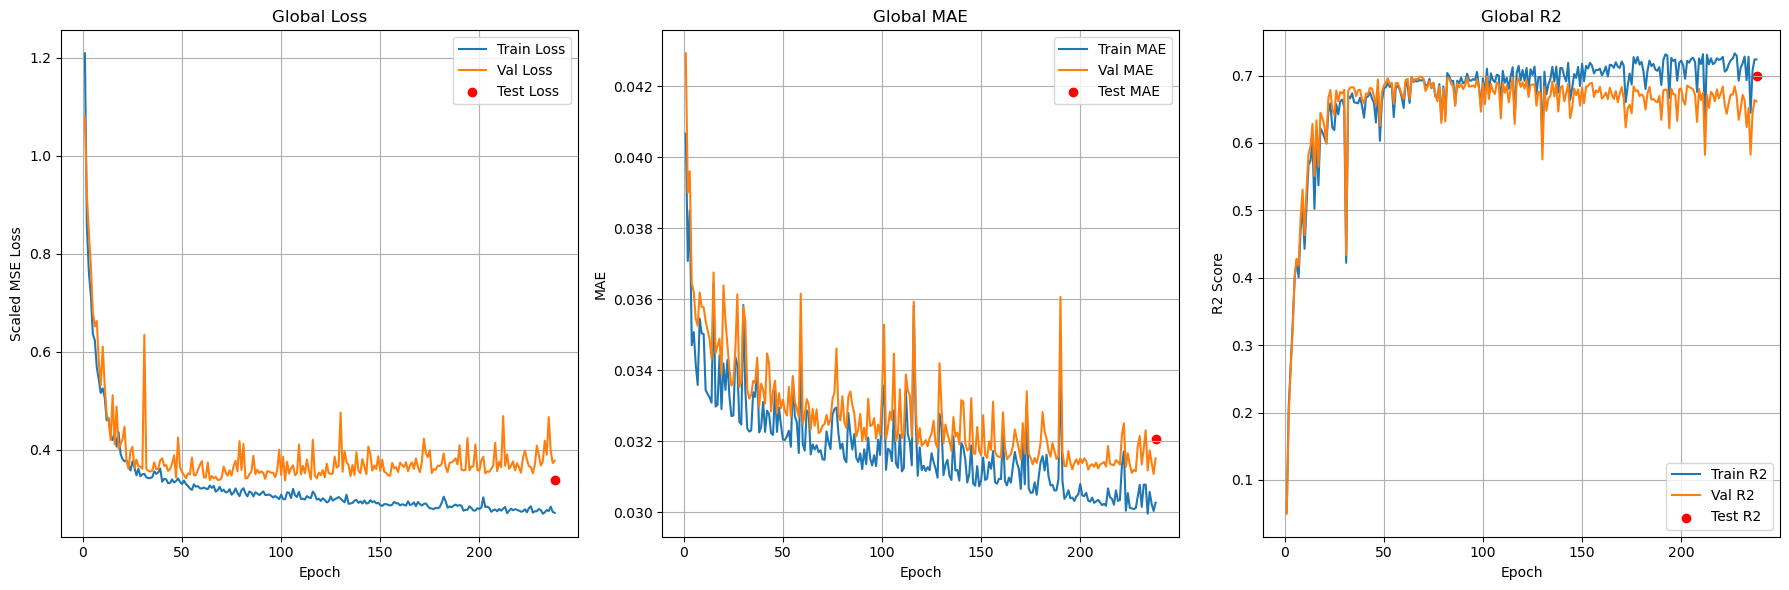

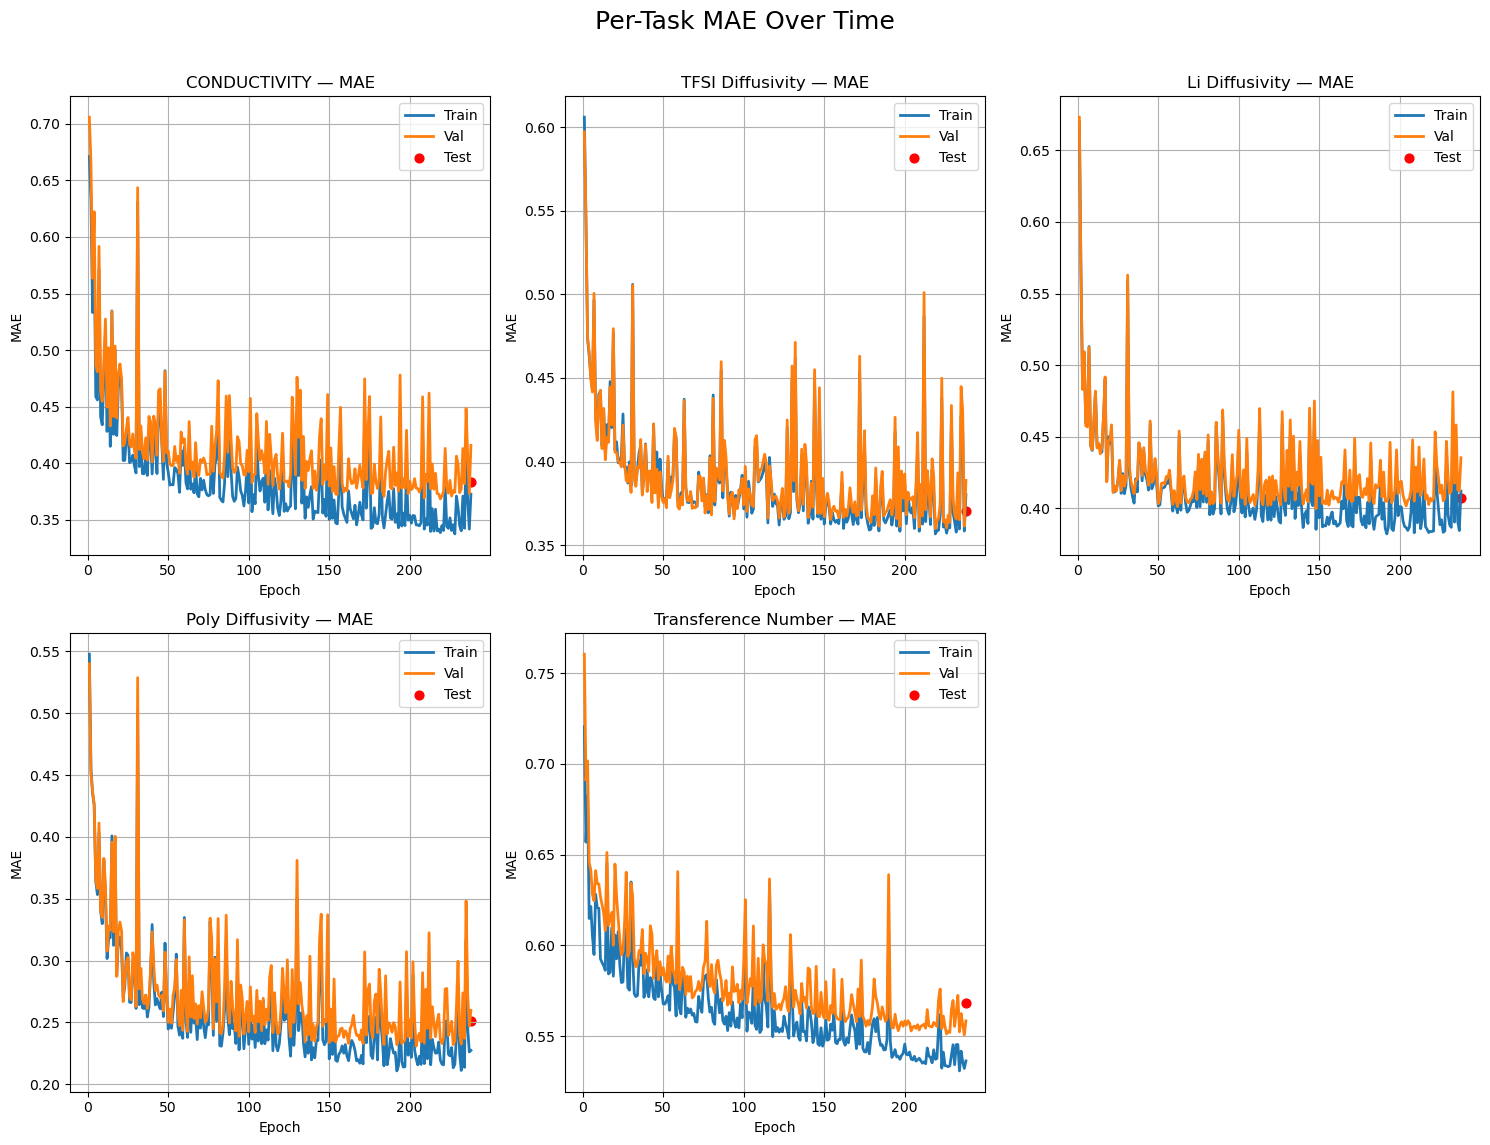

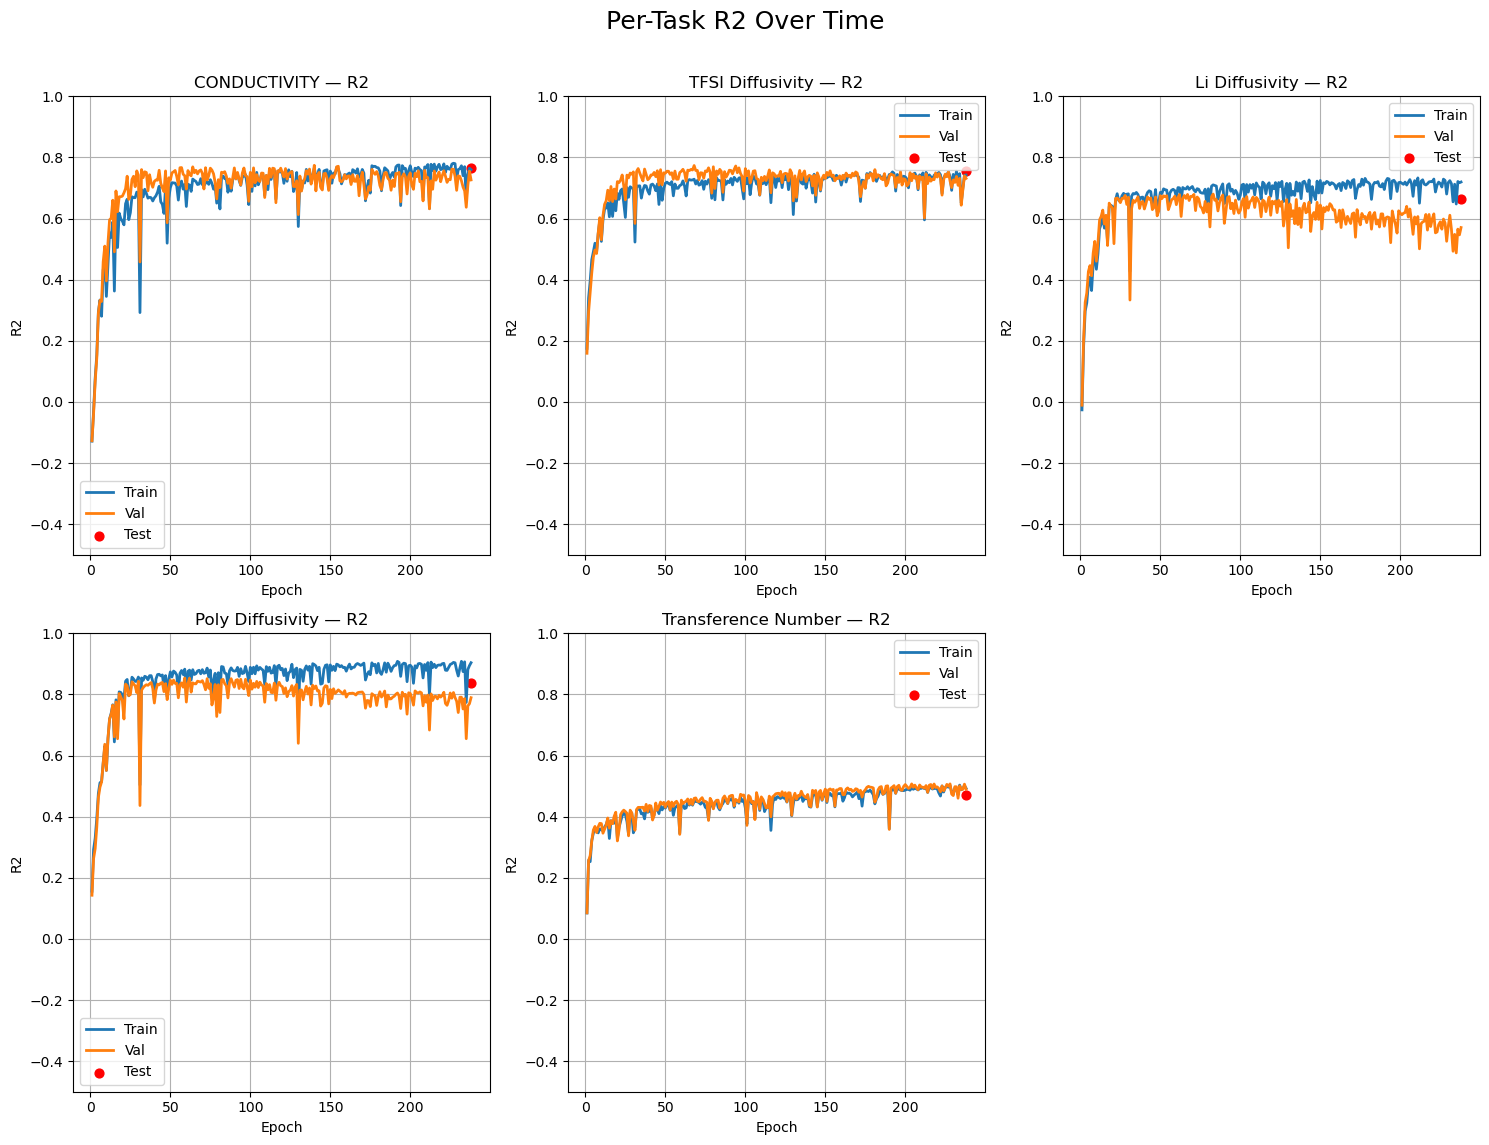

In [ ]:
print('Best score (no molecular features):',score_nomol)
plot_all_metrics(final_metrics_nomol, target_cols_labels, num_epochs=best_params_nomol["num_epochs"])

In [ ]:
print('Best score (with molecular features):',score_withmol)
plot_all_metrics(final_metrics_withmol, target_cols_labels, num_epochs=best_params_withmol["num_epochs"]) #final_metrics3, best_params

In [ ]:
torch.save(final_model_nomol,'./model_out/optimal_model_nomol.pth')
with open("./model_out/optimal_model_nomol_params.txt", "w") as file:
    for k, v in best_params_nomol.items():
        file.write(f"{k}: {v}\n")

torch.save(final_model_withmol,'./model_out/optimal_model_withmol.pth')
with open("./model_out/optimal_model_withmol_params.txt", "w") as file:
    for k, v in best_params_withmol.items():
        file.write(f"{k}: {v}\n")